# Title: Customising intertidal exposure calculations TODO: update <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
### Intertidal Exposure

*Talk about applications and why it is useful to model exposure*

Intertidal coastlines support a wide array of habitats and coastal and marine species.
Low energy tidal flats often support mangrove and seagrass habitats which in turn play host to sea birds, mammals and reptiles. 
Tropical and subtropical intertidal coral reefs provide habitat, food and shelter for abundant marine life while soft sediment coastlines frequently harbour microphytobenthos.
Algaes have a ubiquitous distribution oround Australian coastlines.

The combined effects of tide, sun and air make intertidal environments one of the most dynamic places to live on Earth.
Consequently, ecological niches exist within these environments where optimal conditions can be changeable on timescales that range from daily to seasonally and beyond.
For example, irrespective of their occupying elevation in the intertidal zone, seagrass, coral and algae have all been found to decline under conditions of high solar irradiance when combined with air temperature and aerial exposure.
Seagrass biomass tends to peak around late spring and declines through summer to a winter minima.
Dessication is a major stressor on intertidal algaes, observed under conditions of high irradiance, air temperature and exposure.
Intertidal corals experience a seasonal mortality risk that peaks in early spring when exposure during seasonally low tides combines with high irradiance and low air temperatures.

Furthermore, seagrass dominated intertidal habitats provide foraging ground for marine fauna including turtles and dugongs.
The daily occurrence of exposure in these environments dictates the time available to these species to forage for the nitrogren rich seagrasses of the intertidal zone.
Typically, these species forage intertidal areas at nighttime and during high tides.
Inundation is the inverse of exposure and can be used to model available foraging time.


### Introduction to the Intertidal Exposure calculation method

DEA Intertidal Exposure models the percentage of time that any intertidal pixel of known elevation is exposed from tidal inundation. Exposure is calculated by comparing the pixel elevation back against a high temporal resolution model of tide heights for that location, based on an ensemble tidal modelling approach. Exposure percentage is calculated as the fraction of exposed observations relative to the total number of observations generated in the high temporal resolution tidal model for the 3-year product epoch.

| DEM | High temporal tide model |
|---|---|
| <img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_2019_2021_Elevation.png?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ" width="600" height="300"> | <img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_bay_30min_tide_model.png?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ" width="600" height="300"> |

| Exposure Map | Percentile tide height distribution |
|---|---|
| <img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_2019_2021_Exposure.png?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ" width="600" height="300"> |  <img src="https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Exposure%20method%20concept%20model.png?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ" width="600" height="300"> |

### Custom filtering of the Intertidal Exposure calculation
| Custom filtering | Custom filtered Exposure |
| --- | --- |
| ![image](https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_exposure_options_tidemodelling2.gif?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ) | ![image](https://app.sandbox.dea.ga.gov.au/user/claire.phillips@ga.gov.au/files/dea_intertidal/dea-intertidal/Notebook_planning/Carnot_exposure_options2.gif?_xsrf=MnwxOjB8MTA6MTcxNTgzMzg3MHw1Ol94c3JmfDEzMjpNekF4T0RCaE1XWTRZV0ZqTkdJd1pqazBabVJrTVRVek4yWTBNall5WlRrNlptUTVaamt6T0dabE9ETmxaR1EwWmpVMU1USmlZelUwWVRreU56a3labUZpTWpGak16TmxaV05pWVdGaFltSTBZV0ZoT0RjMk1EQTJNRFppWlRRek5nPT18YWIwNmQyZGU0N2UzNzUzODBiODRjZjBkNTI4YmE2MzE4ZmNiMTUwZjYxMjQ5YWViMjRhODM3MWY3YmVmZDNhZQ) |



## Description

This notebook outlines the general methodology required to calculate intertidal exposure and demonstrates how tailored calculations can be used to investigate specific temporal or spatial influences on exposure times in intertidal ecosystems.

In this notebook, users will:
1. Use a conceptual model to understand how the intertidal exposure calculation is derived
2. Through the use of case studies in a given area of interest, calculate:

    - Full exposure characteristics
    - Temporally filtered exposure characteristics (e.g. wet-season exposure)
    - Spatially filtered exposure characteristics (e.g. high or low tide exposure times)
    - Spatiotemporal filtered exposure characteristics (e.g. wet-season high-tide exposure)

***

### Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [2]:
# cd ../..
%cd /home/jovyan/dea_intertidal/dea-intertidal

/home/jovyan/dea_intertidal/dea-intertidal


In [3]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
import datacube
import cmocean
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython import display
from IPython.core.display import Video
from ipywidgets import Output, GridspecLayout

import odc.geo.xr
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from dea_tools.plotting import display_map, xr_animation, rgb

from intertidal.exposure import exposure

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [5]:
dc = datacube.Datacube(app='Customising_Intertidal_Exposure')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


Friday afternoon:
Adelaide has a huge hightide offset so decided to change locations.

Gulf of Carpentaria is an important waypoint on the East Asian-Australasian flyway for migratory seabirds with a newly assigned Ramsar site eg
https://wetlandinfo.des.qld.gov.au/wetlands/ecology/components/biota/fauna/fauna-taxon/birds/shore-bird/migratory-qld/south-east-gulf-carpentaria.html
https://eaaflyway.net/wp-content/uploads/2020/12/EAAF149_SE-Gulf-Carpentaria-Wernadinga_Final.pdf

This region also hosts significant patches of seagrass, supporting marine mammal and reptile populations in the Gulf eg
https://eatlas.org.au/geonetwork/srv/eng/catalog.search#/metadata/d9a67694-d803-46ca-8f4b-63fc12d51bd1
https://maps.dea.ga.gov.au/#share=s-4VP658YMch1W6EQySU17ALaCtZ4

The high and lowtide offsets are small in the Gulf too so prototype notebook on Leichardt River region on Monday.

In [6]:
# Identify your area of interest as degree lat/lon coordinates as well
# your nominated time period as start and end dates
study_area = "Smithburne_River_Qld"
query_params = dict(y=(-17.05121, -17.10617),
                    x=(140.90808, 140.97289),
                    time=("2016", "2022"))

# 17.05121°S, 140.90808°E
# 17.10617°S, 140.97289°E


# View the area of interest over a generic basemap. Data will be loaded
# inside the red bounding box.
display_map(x=query_params["x"], y=query_params["y"])

## Load Data
Plan: load data over Gladstone Harbour QLD. Use indexed elevation datasets with exposure codes and tide modelling.

In [7]:
# Load DEA Intertidal for the area of interest, and mask out invalid
# nodata values
ds = dc.load(product="ga_s2ls_intertidal_cyear_3", **query_params)
ds = mask_invalid_data(ds)

# Additionally, load the median annual Landsat 8 imagery for the area
# of interest, and mask out invalid nodata values
geomad_ds = dc.load(
    product="ga_ls8c_nbart_gm_cyear_3",
    measurements=["red", "green", "blue"],
    resampling="cubic",
    like=ds,
)
geomad_ds = mask_invalid_data(geomad_ds)

# Add the geomad data layers into the master dataset

ds['red'] = geomad_ds['red']
ds['green'] = geomad_ds['green']
ds['blue'] = geomad_ds['blue']

# Inspect the combined DEA Intertidal and Geomad dataset
ds

<xarray.Dataset> Size: 202MB
Dimensions:                (time: 7, y: 654, x: 734)
Coordinates:
  * time                   (time) datetime64[ns] 56B 2016-07-01T23:59:59.9999...
  * y                      (y) float64 5kB -1.85e+06 -1.85e+06 ... -1.857e+06
  * x                      (x) float64 6kB 9.495e+05 9.495e+05 ... 9.569e+05
    spatial_ref            int32 4B 3577
Data variables: (12/15)
    elevation              (time, y, x) float32 13MB nan nan nan ... nan nan nan
    elevation_uncertainty  (time, y, x) float32 13MB nan nan nan ... nan nan nan
    exposure               (time, y, x) float32 13MB nan nan nan ... nan nan nan
    ta_hat                 (time, y, x) float32 13MB 1.682 1.682 ... 2.019 2.019
    ta_hot                 (time, y, x) float32 13MB 1.434 1.435 ... 1.889 1.889
    ta_lot                 (time, y, x) float32 13MB -1.338 -1.338 ... -1.753
    ...                     ...
    ta_spread              (time, y, x) float32 13MB 87.0 87.0 ... 93.0 93.0
    qa_ndwi_corr           (time, y, x) float32 13MB nan nan nan ... nan nan nan
    qa_ndwi_freq           (time, y, x) float32 13MB 100.0 100.0 ... 0.0 0.0
    red                    (time, y, x) float32 13MB 651.0 643.0 ... 2.019e+03
    green                  (time, y, x) float32 13MB 1.202e+03 ... 1.793e+03
    blue                   (time, y, x) float32 13MB 964.0 957.0 ... 1.338e+03
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Plot all-epoch elevation and exposure
Plan: calculate exposure for all timesteps in the epoch. Briefly interpret results. Segue into case study examples.

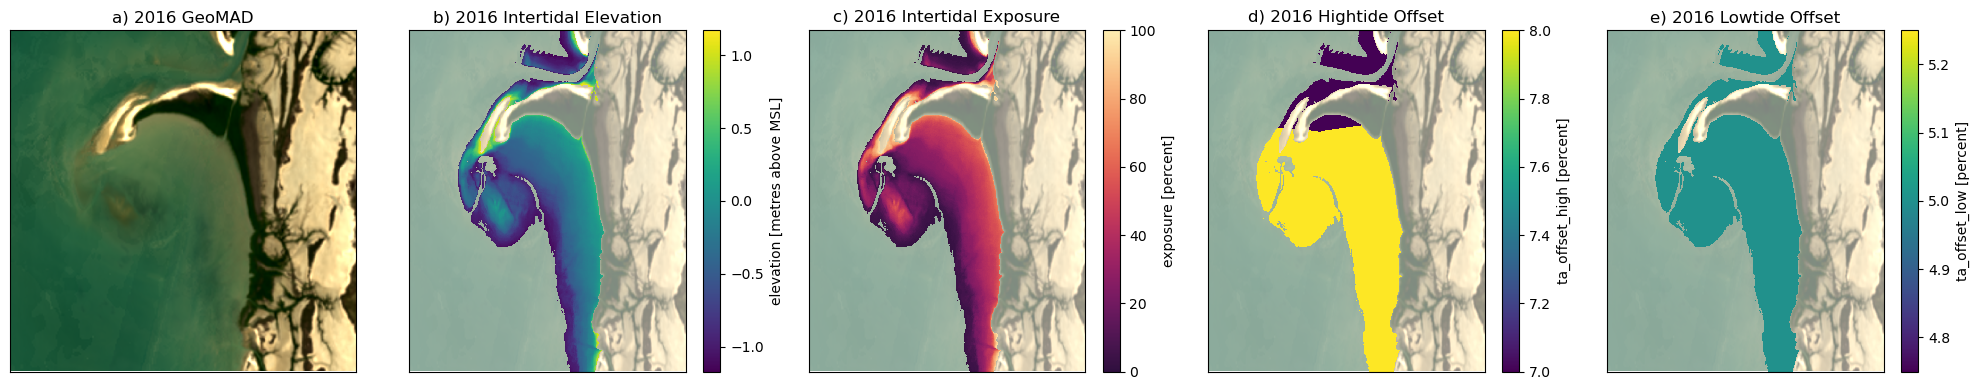

In [25]:
# Plot the intertidal elevation and uncertainty for 2019

# Identify a single timestep to inspect
time = np.datetime_as_string(ds.time.values, unit="Y")[0]

# Setup the figure
fig, axes = plt.subplots(ncols=5, figsize=(20, 4))

# Assign the datasets to the figure
rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[0])

rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[1], alpha=0.5)
ds.elevation.sel(time=time).plot(ax=axes[1], cmap="viridis")

rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[2], alpha=0.5)
ds.exposure.sel(time=time).plot(ax=axes[2], cmap=cmocean.cm.matter_r, vmin=0, vmax=100)

rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[3], alpha=0.5)
ds.ta_offset_high.sel(time=time).where(ds.elevation.sel(time=time).notnull()).plot(ax=axes[3])#, cmap="viridis")

rgb(ds.sel(time=time), bands=["red", "green", "blue"], ax=axes[4], alpha=0.5)
ds.ta_offset_low.sel(time=time).where(ds.elevation.sel(time=time).notnull()).plot(ax=axes[4])#, cmap="viridis")

labels = [
          f"a) {time} GeoMAD",
          f"b) {time} Intertidal Elevation",
          f"c) {time} Intertidal Exposure",
          f"d) {time} Hightide Offset",
          f"e) {time} Lowtide Offset"
         ]

for ax, title in zip(axes.reshape(-1), labels):
    ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
    ax.set(xlabel=None, ylabel=None)
    ax.set_title(title)


plt.tight_layout()


### Interpretation

The default Smithburne River, QLD, location is located on the eastern banks of Australia's Gulf of Carpentaria.
The area of interest for this study is a sand spit which has been developing over recent decades and is being stabilised by the development of mangrove forest.
Panel a shows the location in satellite imagery.
Note that the tide level is quite high in this image which represents the median satellite image capture over the annual period denoted in the panel title.

Panels b-e represent some of the intertidal features mapped for this location from the DEA Intertidal dataset suite, for the three year epoch centered around the year in the panel title.
The intertidal digital elevation model is shown in panel b, with a tide range within approximately +/- 1.5 m above mean sea level.
This elevation model is a primary input into the intertidal exposure model (panel c).
Intertidal exposure values represent the percentage of time during the epoch that every 10 m<sup>2</sup> pixel was exposed to the air. 
Although this location appears to represent a fairly complete range of modelled exposure values (%), careful examination shows that extrema values are not captured by this model.
This is because there is an offset in satellite image acquisition that fails to capture tide heights at both ends of the tidal spectrum (panels d,e) which gets reflected in the exposure model.
This concept is captured by mapping of high and low tide offsets during the epoch of interest (panels d,e).
These panels show that satellites failed to image this location during the top 7-8 % of high tides (panel d) and during the bottom 5 % of low tides (panel e).
These offsets should be kept in mind when interpreting the spatial outputs of any exposure mapping undertaken using this dataset.

As demonstrated in the [method](#Background), intertidal exposure is here calculated by comparing tide heights from a high temporal resolution tide model to and elevation model.
By filtering out time-periods of interest from the tide model, customised exposure maps can be generated.
The following case studies explore this application by mapping single and merged filters to explore the influence of seasonality and solar inundation on intertidal exposure.

## Case study 1 - Mapping exposure by season

Seasonality is a useful way to explore habitat dynamics in specific relation to migratory seabirds.
These global travellers migrate from breeding grounds in Siberia and Alaska, through Asia, to Australia to forage, rest and rebuild their energy reserves each year.
Arriving in Australia's north around September each year, these birds disperse across Australia, returning to the north around March where they prepare to return to their Northern Hemisphere breeding grounds.

Migratory seabirds rely heavily on intertidal zones.
They are dependent on both the highest elevations to roost and rest and the lowest elevations to forage and feed, preferring best to occupy locations where roosting and foraging grounds are co-located.

This example maps intertidal exposure by season to investigate its influence on seabird occupation space across the year.

In [8]:
# Identify the filters to use to identify datetimes of interest from the high res tidal model
filters = ['unfiltered', 'summer', 'autumn', 'winter', 'spring']
filters_combined = None ## Must be a list of tuples containing one temporal and spatial filter each, eg None or [('Einter','Lowtide')]

exposure_ds, modelledtides_ds, modelledtides_1d,timeranges, peaks = exposure(
    dem=ds.elevation.sel(time=time),
    start_date=str(np.datetime64(time) - np.timedelta64(1,'Y')),
    end_date=str(np.datetime64(time) + np.timedelta64(1,'Y')),
    modelled_freq = '30 min',
    # tide_model="ensemble",
    # tide_model_dir=tide_model_dir,
    filters=filters,
    filters_combined=filters_combined,
)

# Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(exposure_ds.keys()):
    ds[f'exposure_{str(x)}']=exposure_ds[str(x)]#.squeeze(dim='time')

# Separate from the master dataset (ds) the variables of interest
fc = ['exposure_unfiltered']
for e in filters:
    fc.append('exposure_'+e)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [01:24<00:00, 16.83s/it]


Returning low resolution tide array


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering timesteps for summer
Filtering timesteps for autumn
Filtering timesteps for winter
Filtering timesteps for spring
Calculating unfiltered exposure
Calculating summer exposure
Calculating autumn exposure
Calculating winter exposure
Calculating spring exposure


In [31]:
# View monthly exposure

fig = ds[fc].to_array().isel(time=0).plot(col='variable', cmap=cmocean.cm.matter_r, vmin=0,vmax=100)

for ax,title in zip(fig.axs.flat, fc):
    ax.set_title(title)
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

NameError: name 'fc' is not defined

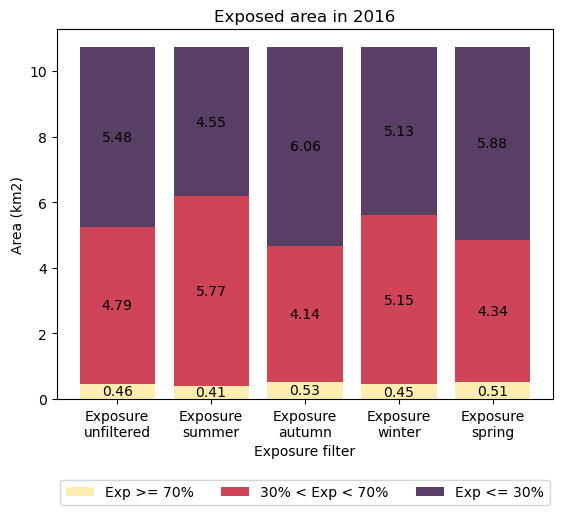

In [10]:
# Explore monthly differences in exposure by area

# Quantify exposed areas by categorising 3 broad groupings of exposure values and
# calculating the pixel contributions to each group

# Establish some variables to capture the outputs
exp70_100 = []
exp30_70 = []
exp0_30 = []
labels = []
  
# Separate the exposure datasets into categories and count the pixels per category
for x in ds[fc].var():
    if 'exp' in x:
        # Prepare the labels for the various exposure datasets        
        if x == 'exposure':
            labels.append(f'Exposure\nUnfiltered')
        if 'exposure_' in x:
            y=x.split('ure_')[-1]
            if '_' in y:
                z=y.split('_')
                labels.append(f'Exposure\n{z[0]}\n{z[-1]}')
            else:
                labels.append(f'Exposure\n{y}')
        # Count the number of pixels exposed between 0 and 100 % of filtered time
        a=ds[str(x)].sel(time=time).count(dim=("x","y")).values

        # Count the number of pixels exposed between 0 and 70 % of filtered time
        b=ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) < 70).count(dim=("x","y")).values

        # Count the number of pixels exposed between 0 and 30 % of filtered time
        c = ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) <= 30).count(dim=("x","y")).values

        # Calculate the pixel count contributions to each class and translate 10m2 pixel counts to area as km2
        exp70_100.append(round((a[0]-b[0])*0.0001,2))  
        exp30_70.append(round((b[0]-c[0])*0.0001,2))
        exp0_30.append(round((c[0])*0.0001,2))

# Prepare the summary data to plot

exp_counts = {"Exp >= 70%": (np.array(exp70_100)),#*0.0001,
              "30% < Exp < 70%": (np.array(exp30_70)),#*0.0001,
              "Exp <= 30%": np.array(exp0_30)}#*0.0001}
# Set the y-axis minimum for this stacked bar chart
bottom = np.zeros(5)
# Set the bar width
width = 0.8
# Set the colour scheme
cmap = cmocean.cm.matter_r
# Prepare the figure
fig, ax = plt.subplots()

# Plot the summary datasets on a stacked bar chart.
for var, counts in exp_counts.items():
    
    # Set the colour and transparency for each bar
    if var == list(exp_counts.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(exp_counts.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(exp_counts.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax.bar(labels, counts, width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax.bar_label(p, label_type='center')

# Prepare the legend
ax.legend(loc="upper center",
             ncol=3,
             bbox_to_anchor=(0.5, -0.2),
             frameon=True)

# Prepare the labels
ax.set_ylabel("Area (km2)")
ax.set_xlabel("Exposure filter")

# Set the figure subtitle
ax.set_title(f"Exposed area in {time}")

plt.show()

### Interpretation

Compared to the all-epoch exposure map, seasonal maps of exposure for this epoch at Smithburne River were not particularly revealing - though slight differences were discernable.
Summarising the spatial extent of exposure classes for this area of interest was arguable more useful, demonstrating why this area forms part of the important staging grounds for seabird arrivals and departures from Australia.

When migratory seabirds arrive during the Austral spring, they are hungry and energy-depleted.
When they depart during Autumn, they are stock piling energy reserves for their migration to their breeding grounds.
At this location, the largest proportions of low tide foraging grounds (exposed less than 30 % of the time) were available during the spring and autumn.
Coincidentally, the smallest proportion of low tide foraging ground was available during the Austral summer which may be a contributing factor to  continuing seabird migrations across southern Australia during the warmer months.

Similarly, high tide areas (exposed for more than 70 % of the time) for roosting were also greater during spring and autumn.

## Case study 2 - Mapping daily exposure by season

Corals, seagrass and algae are all sensitive to combined effects of solar irradiation and aerial exposure. Investigate how addition of daily and seasonal filtering affects exposure results.


### All below is draft text from earlier version of notebook - needs review

When considering intertidal exposure, there are many cases where it is advantageous to query exposure times for specific periods in either time or space.

The intertidal exposure algorithm supports temporal filtering of the input time period by any of the following options:
- Monthly (e.g. 'Jan', 'Feb', 'Mar' etc)
- Austral Season (e.g. 'Summer', 'Autumn', 'Winter' or 'Spring')
- Equatorial Season (e.g. 'Dry' or 'Wet')
- Solar (e.g. 'Daylight' or 'Night')

For example, you might be interested in exploring variations in intertidal exposure time to support the characterisation of intertidal seagrass habitat.
To explore exposure times during seagrass germination periods, you might select a 'Wet' season filter.
If you wanted to explore exposure during the peak growing period, you could select the 'Summer' filter.
You can even combine filters.
To quantify the summer solar illumination exposure time, you would combine the 'Summer' and 'Daylight' filters.

These filters are set as follows in the next cell. To experiment with other temporal filters, simply replace the `filters` or `filters_combined` values.

    filters = ['Wet','Summer']
    filters_combined=[('Summer','Daylight')]
### More case study reference material
Scenario: The 2024 QLD DES/DCCEEW Wetland Management Strategy identified goals and future directions for wetland management in Queensland.
These environments are critical to the success of shorebirds, including many migratory species and a wide range of seabirds.
The wetland management strategy identified two objectives relating to the mapping of shorebird habitat in Queensland:
1) Map and make available the location and shorebird use of high tide roost site information
2) Map and make available the location and shorebird use of shorebird feeding areas.

In this example, users will calculate intertidal exposure during average hightide periods to inform shorebird high tide roost site mapping.
Following this, the exercise will be repeated for average lowtide periods to inform calculations of foraging time and occupation space in low tide environments which are critical feeding environments for shore and sea birds.


In [32]:
# Identify the filters to use to identify datetimes of interest from the high res tidal model
filters = None
filters_combined = [("daylight","summer"),("daylight","autumn"),("daylight","winter"),("daylight","spring")]

# Use the default settings to calculate a high temporal resolution tide model and
# filter out the nominated datetimes to calculate exposure. Default settings
# include a tide model frequency of 30 minutes and FES2014 tide modelling
exposure_ds, modelledtides_ds, modelledtides_1d,timeranges, peaks = exposure(
    dem=ds.elevation.sel(time=time),
    start_date=str(np.datetime64(time) - np.timedelta64(1,'Y')),
    end_date=str(np.datetime64(time) + np.timedelta64(1,'Y')),
    modelled_freq = '30 min',
    filters=filters,
    filters_combined=filters_combined,
)

# Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(exposure_ds.keys()):
    # ds[f'exposure_{str(x)}_{time}']=exposure_ds[str(x)].squeeze(dim='time')
    ds[f'exposure_{str(x)}']=exposure_ds[str(x)]#.squeeze(dim='time')
# View the master dataset with new variables added   
ds

# Separate from the master dataset (ds) the variables of interest
fc = ['exposure_unfiltered']
for e in filters_combined:
    fc.append('exposure_'+e[0]+'_'+e[1])

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [01:27<00:00, 17.47s/it]


Returning low resolution tide array
Filtering timesteps for daylight
Filtering timesteps for summer
Filtering timesteps for autumn
Filtering timesteps for winter
Filtering timesteps for spring
Calculating unfiltered exposure
Calculating daylight exposure
Calculating summer exposure
Calculating autumn exposure
Calculating winter exposure
Calculating spring exposure
Calculating daylight_summer exposure
Calculating daylight_autumn exposure
Calculating daylight_winter exposure
Calculating daylight_spring exposure


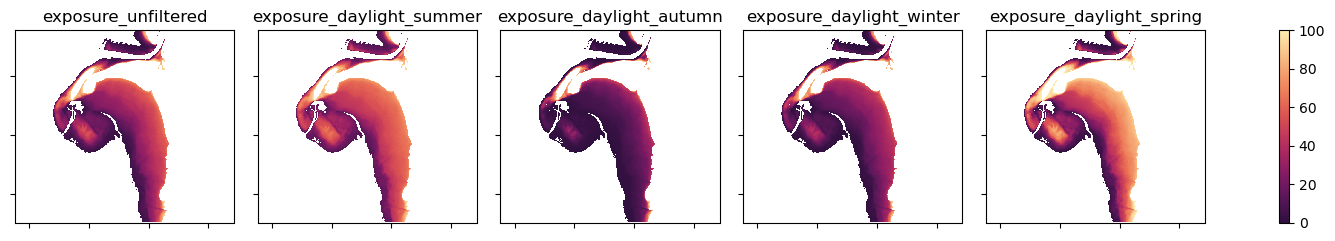

In [33]:
# View the filtered outputs
fig = ds[fc].to_array().isel(time=0).plot(col='variable', cmap=cmocean.cm.matter_r, vmin=0,vmax=100)

for ax,title in zip(fig.axs.flat, fc):
    ax.set_title(title)
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

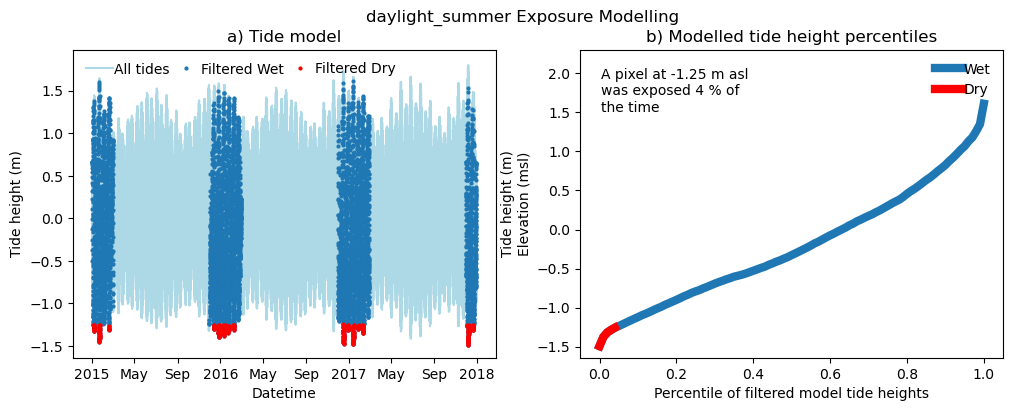

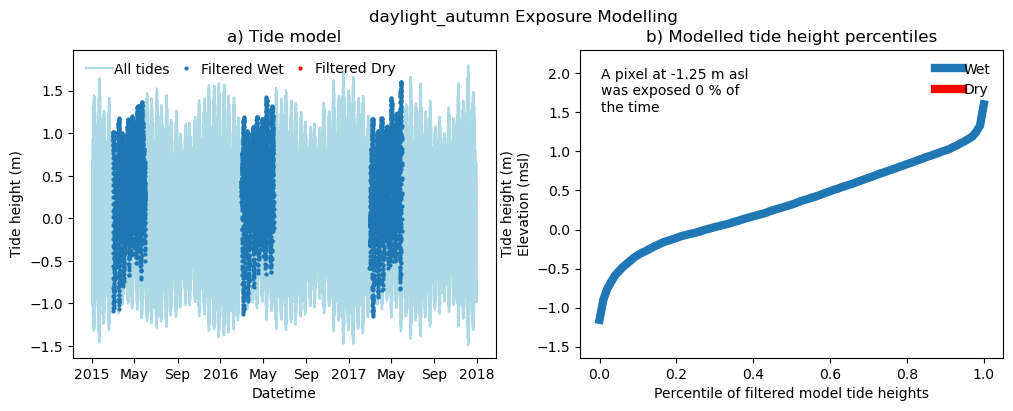

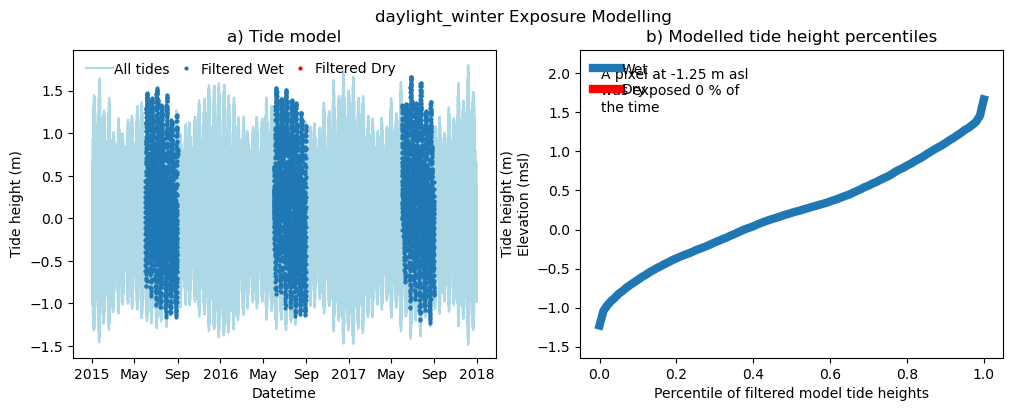

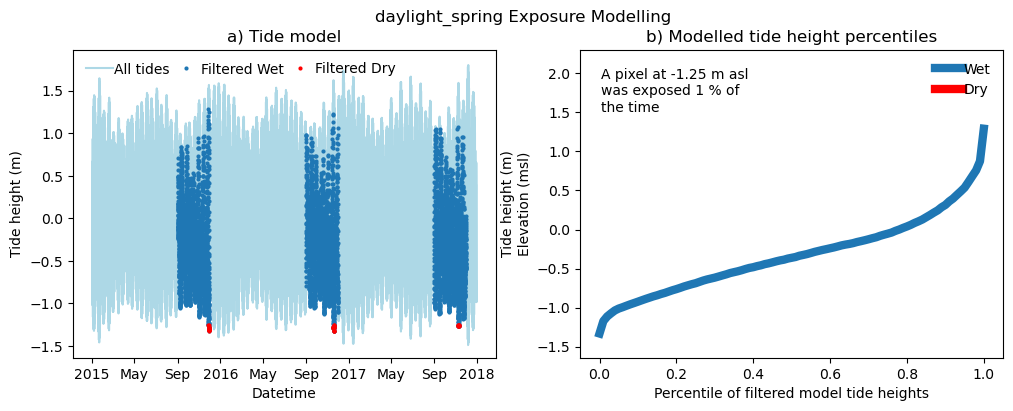

In [34]:
## Plot generation demonstrating exposure filter options

# Nominate which filter to plot from filters list eg filters[x]
# x = 5
filters_low=list(exposure_ds.drop_vars(['daylight','summer','autumn','winter','spring','unfiltered']).keys())
for x in range(0,len(filters_low)):

    tidem = -1.25
    exp = abs(modelledtides_ds[filters_low[x]].where(modelledtides_ds[filters_low[x]]) - tidem).idxmin(dim='quantile')*100

    fig, ax = plt.subplots(1,2, figsize=(12,4))

    # For filtered tide models

    # plot all tides
    modelledtides_1d.plot(ax=ax[0], label='All tides', color='lightblue', zorder=1)

    #plot filtered tides
    modelledtides_1d.sel(time=timeranges[filters_low[x]]).plot(linestyle='',marker='.', ax=ax[0], markeredgecolor='none', label='Filtered Wet', zorder=2)
    # if filters_low[x] == 'low_tide':
    #     ax[0].hlines(peaks[filters_low[x]].mean(),
    #                  timeranges[filters_low[x]][0],
    #                  timeranges[filters_low[x]][-1], 
    #                  color='black', 
    #                  zorder=4,
    #                 label='Peaks mean')
    # else:
    #     ax[0].hlines(modelledtides_1d.sel(time=timeranges[filters_low[x]]).max(),
    #                  timeranges[filters_low[x]][0],
    #                  timeranges[filters_low[x]][-1], 
    #                  color='black', 
    #                  zorder=4,
    #                 label='Peaks mean')
    # peaks[filters_low[x]].plot(ax=ax[0], marker='o', color='black', linestyle='', markersize='0.3', label=f'{filters_low[x]} peaks')

    # plot demonstration tides (for concept model where elevation = tidem)
    modelledtides_1d.sel(
        time=timeranges[filters_low[x]]).where(
        modelledtides_1d.sel(time=timeranges[filters_low[x]])<tidem).plot(
        linestyle='',marker='.', ax=ax[0],color='red', markeredgecolor='none', label='Filtered Dry', zorder=3)

    # plot the cumulative frequency exposure curve
    modelledtides_ds[filters_low[x]].plot(ax=ax[1],label='Wet', color='C0', linewidth=6)
    modelledtides_ds[filters_low[x]].where(modelledtides_ds[filters_low[x]]<tidem).plot(ax=ax[1], color='red', label='Dry', linewidth=6)

    ax[0].set_title('a) Tide model')
    ax[0].set_ylabel('Tide height (m)')
    ax[0].set_ylim(ymin=modelledtides_1d.min()*1.1 ,ymax=modelledtides_1d.max()*1.1)
    ax[0].set_xlabel('Datetime')
    ax[0].legend(frameon=False, ncol=3, handletextpad=0.05, columnspacing=0.2)

    ax[1].set_title('b) Modelled tide height percentiles')
    ax[1].set_ylabel('Tide height (m)\nElevation (msl)')
    ax[1].set_ylim(ymin=modelledtides_1d.min()*1.1 , ymax=modelledtides_1d.max()+0.5)
    ax[1].set_xlabel('Percentile of filtered model tide heights')
    ax[1].legend(frameon=False, handletextpad=0.05, columnspacing=0.2)
    ax[1].annotate(f'A pixel at {tidem} m asl\nwas exposed {int(exp.values)} % of\nthe time', (0.05, 0.8), xycoords='axes fraction')

    fig.suptitle(f'{filters_low[x]} Exposure Modelling')
    plt.savefig(f'{filters_low[x]}_Exp_concept_tideheight_filter')

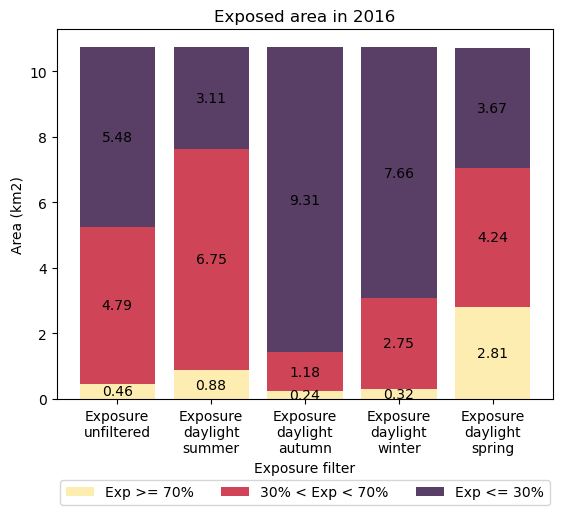

In [17]:
# Quantify exposed areas by categorising 3 broad groupings of exposure values and
# calculating the pixel contributions to each group

# Establish some variables to capture the outputs
exp70_100 = []
exp30_70 = []
exp0_30 = []
labels = []
    
# Separate the exposure datasets into categories and count the pixels per category
for x in ds[fc].var():
    if 'exp' in x:
        # Prepare the labels for the various exposure datasets        
        if x == 'exposure':
            labels.append(f'Exposure\nUnfiltered')
        if 'exposure_' in x:
            y=x.split('ure_')[-1]
            if '_' in y:
                z=y.split('_')
                labels.append(f'Exposure\n{z[0]}\n{z[-1]}')
            else:
                labels.append(f'Exposure\n{y}')
        # Count the number of pixels exposed between 0 and 100 % of filtered time
        a=ds[str(x)].sel(time=time).count(dim=("x","y")).values

        # Count the number of pixels exposed between 0 and 70 % of filtered time
        b=ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) < 70).count(dim=("x","y")).values

        # Count the number of pixels exposed between 0 and 30 % of filtered time
        c = ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) <= 30).count(dim=("x","y")).values

        # Calculate the pixel count contributions to each class and translate 10m2 pixel counts to area as km2
        exp70_100.append(round((a[0]-b[0])*0.0001,2))  
        exp30_70.append(round((b[0]-c[0])*0.0001,2))
        exp0_30.append(round((c[0])*0.0001,2))

# Prepare the summary data to plot

exp_counts = {"Exp >= 70%": (np.array(exp70_100)),#*0.0001,
              "30% < Exp < 70%": (np.array(exp30_70)),#*0.0001,
              "Exp <= 30%": np.array(exp0_30)}#*0.0001}
# Set the y-axis minimum for this stacked bar chart
bottom = np.zeros(5)
# Set the bar width
width = 0.8
# Set the colour scheme
cmap = cmocean.cm.matter_r
# Prepare the figure
fig, ax = plt.subplots()

# Plot the summary datasets on a stacked bar chart.
for var, counts in exp_counts.items():
    
    # Set the colour and transparency for each bar
    if var == list(exp_counts.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(exp_counts.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(exp_counts.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax.bar(labels, counts, width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax.bar_label(p, label_type='center')

# Prepare the legend
ax.legend(loc="upper center",
             ncol=3,
             bbox_to_anchor=(0.5, -0.2),
             frameon=True)

# Prepare the labels
ax.set_ylabel("Area (km2)")
ax.set_xlabel("Exposure filter")

# Set the figure subtitle
ax.set_title(f"Exposed area in {time}")

plt.show()

## Case study 3 - Mapping nightly inundation by month

Mapping time available at night for intertidal (seagrass) foraging by turtles and dugongs by using inverse of exposure to model inundation times.


In [18]:
# Calculate exposure for the nominated filters: night and months January to December

# Identify the filters to use to identify datetimes of interest from the high res tidal model
filters = None
filters_combined = [("night","jan"),
                    ("night","feb"),
                    ("night","mar"),
                    ("night","apr"),
                    ("night","may"),
                    ("night","jun"),
                    ("night","jul"),
                    ("night","aug"),
                    ("night","sep"),
                    ("night","oct"),
                    ("night","nov"),
                    ("night","dec")
                   ]


exposure_ds, modelledtides_ds, modelledtides_1d,timeranges, peaks = exposure(
    dem=ds.elevation.sel(time=time),
    start_date=str(np.datetime64(time) - np.timedelta64(1,'Y')),
    end_date=str(np.datetime64(time) + np.timedelta64(1,'Y')),
    modelled_freq = '30 min',
    filters=filters,
    filters_combined=filters_combined,
)

# Separate from the master dataset (ds) the variables of interest
fc = ['exposure_unfiltered']
for e in filters_combined:
    fc.append('exposure_'+e[0]+'_'+e[1])
    
    # Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(exposure_ds.keys()):
    # ds[f'exposure_{str(x)}_{time}']=exposure_ds[str(x)].squeeze(dim='time')
    ds[f'exposure_{str(x)}']=exposure_ds[str(x)]#.squeeze(dim='time')

# Calculate the inverse of exposure to convert to inundation 
inundation_ds = abs(100-exposure_ds)

# Separate from the master dataset (ds) the variables of interest
fc = ['inundation_unfiltered']
for e in filters_combined:
    fc.append('inundation_'+e[0]+'_'+e[1])
    
# Add each filtered dataset as a variable layer in the master dataset 'ds'
for x in list(inundation_ds.keys()):
    # ds[f'exposure_{str(x)}_{time}']=exposure_ds[str(x)].squeeze(dim='time')
    ds[f'inundation_{str(x)}']=inundation_ds[str(x)]#.squeeze(dim='time')

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [01:26<00:00, 17.30s/it]


Returning low resolution tide array
Filtering timesteps for night
Filtering timesteps for jan
Filtering timesteps for feb
Filtering timesteps for mar
Filtering timesteps for apr
Filtering timesteps for may
Filtering timesteps for jun
Filtering timesteps for jul
Filtering timesteps for aug
Filtering timesteps for sep
Filtering timesteps for oct
Filtering timesteps for nov
Filtering timesteps for dec
Calculating unfiltered exposure
Calculating night exposure
Calculating jan exposure
Calculating feb exposure
Calculating mar exposure
Calculating apr exposure
Calculating may exposure
Calculating jun exposure
Calculating jul exposure
Calculating aug exposure
Calculating sep exposure
Calculating oct exposure
Calculating nov exposure
Calculating dec exposure
Calculating night_jan exposure
Calculating night_feb exposure
Calculating night_mar exposure
Calculating night_apr exposure
Calculating night_may exposure
Calculating night_jun exposure
Calculating night_jul exposure
Calculating night_aug 

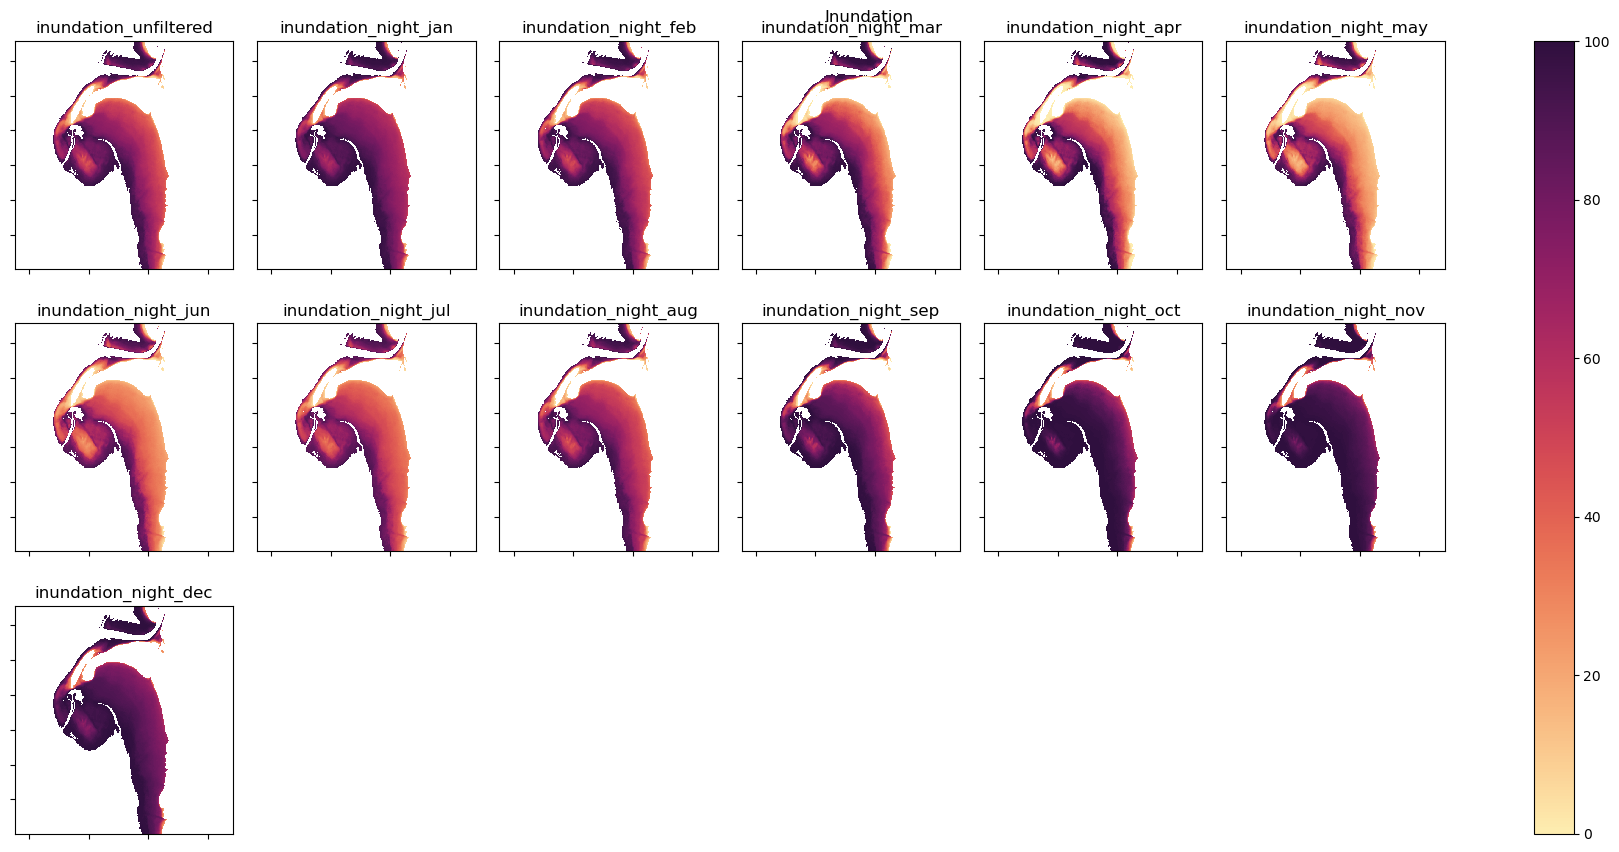

In [28]:
# View the filtered inundation outputs

fig = ds[fc].sel(time=time).to_array().plot(col='variable', col_wrap=6, cmap=cmocean.cm.matter, vmin=0,vmax=100)# col_wrap=13,
fig.fig.suptitle('Inundation')

for ax,title in zip(fig.axs.flat, fc):
    ax.set_title(title)
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

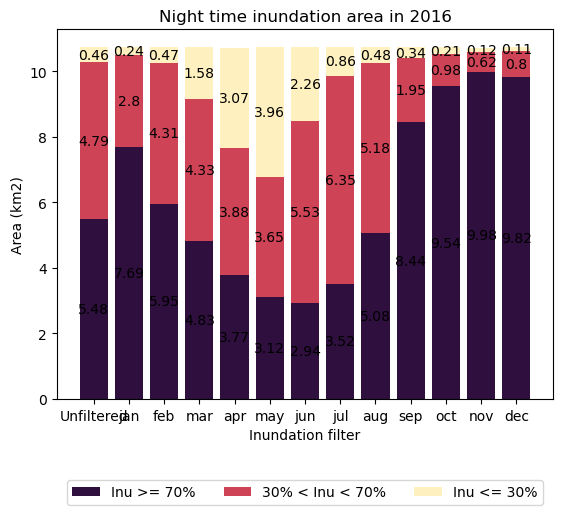

In [22]:
# Summarise the months using the bar plot summary

# Quantify exposed areas by categorising 3 broad groupings of exposure values and
# calculating the pixel contributions to each group

# Establish some variables to capture the outputs
inu70_100 = []
inu30_70 = []
inu0_30 = []
labels = []
   
# Separate the exposure datasets into categories and count the pixels per category
for x in ds[fc].var():
    
    # Prepare the labels for the various exposure datasets        
    if x == 'inundation_unfiltered':
        labels.append(f'Unfiltered')
    if 'inundation_night_' in x:
        y=x.split('night_')[-1]
        if '_' in y:
            z=y.split('_')
            labels.append(f'{z[0]}\n{z[-1]}')
        else:
            labels.append(f'{y}')
    # Count the number of pixels exposed between 0 and 100 % of filtered time
    a=ds[str(x)].sel(time=time).count(dim=("x","y")).values

    # Count the number of pixels exposed between 0 and 70 % of filtered time
    b=ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) < 70).count(dim=("x","y")).values

    # Count the number of pixels exposed between 0 and 30 % of filtered time
    c = ds[str(x)].sel(time=time).where(ds[str(x)].sel(time=time) <= 30).count(dim=("x","y")).values

    # Calculate the pixel count contributions to each class and translate 10m2 pixel counts to area as km2
    inu70_100.append(round((a[0]-b[0])*0.0001,2))  
    inu30_70.append(round((b[0]-c[0])*0.0001,2))
    inu0_30.append(round((c[0])*0.0001,2))

# Prepare the summary data to plot

inu_counts = {"Inu >= 70%": (np.array(inu70_100)),#*0.0001,
              "30% < Inu < 70%": (np.array(inu30_70)),#*0.0001,
              "Inu <= 30%": np.array(inu0_30)}#*0.0001}
# Set the y-axis minimum for this stacked bar chart
bottom = np.zeros(13)
# Set the bar width
width = 0.8
# Set the colour scheme
cmap = cmocean.cm.matter
# Prepare the figure
fig, ax = plt.subplots()

# Plot the summary datasets on a stacked bar chart.
for var, counts in inu_counts.items():
    
    # Set the colour and transparency for each bar
    if var == list(inu_counts.keys())[0]:
        color=cmap(1.0)
        alpha=1
    if var == list(inu_counts.keys())[1]:
        color=cmap(0.5)
        alpha=1
    if var == list(inu_counts.keys())[2]:
        color=cmap(0)
        alpha=0.8
    # Add the bar to the plot
    p = ax.bar(labels, counts, width, label=var, bottom=bottom,color=color, alpha=alpha)
    # Prepare to stack the next bar
    bottom += counts
    # Label each bar with its contribution to the total area
    ax.bar_label(p, label_type='center')

# Prepare the legend
ax.legend(loc="upper center",
             ncol=3,
             bbox_to_anchor=(0.5, -0.2),
             frameon=True)

# Prepare the labels
ax.set_ylabel("Area (km2)")
ax.set_xlabel("Inundation filter")

# Set the figure subtitle
ax.set_title(f"Night time inundation area in {time}")

plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [23]:
print(datacube.__version__)

1.8.18


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

In [24]:
# # Calculate the difference between the filtered and unfiltered exposure datasets to confirm that changes were detected

# # Calculate the differences relative to the unfiltered exposure dataset
# del_exp_Wet =((ds['exposure'].sel(time=time))-(ds['exposure_Wet_2016'])).astype('int').where(ds['exposure'].sel(time=time).notnull())
# del_exp_Sum =((ds['exposure'].sel(time=time))-(ds['exposure_Summer_2016'])).astype('int').where(ds['exposure'].sel(time=time).notnull())
# del_exp_Day =((ds['exposure'].sel(time=time))-(ds['exposure_Daylight_2016'])).astype('int').where(ds['exposure'].sel(time=time).notnull())
# del_exp_Sum_Day =((ds['exposure'].sel(time=time))-(ds['exposure_Summer_Daylight_2016'])).astype('int').where(ds['exposure'].sel(time=time).notnull())

# # Combine layers for simplified plotting
# delta = del_exp_Wet.to_dataset(name='delta_exp_Wet')
# delta['delta_exp_Sum']=del_exp_Sum
# delta['delta_exp_Day']=del_exp_Day
# delta['delta_exp_Sum_Day']=del_exp_Sum_Day

# # Plot the differences relative to the unfiltered exposure dataset
# fig=delta[[
#     'delta_exp_Wet',
#     'delta_exp_Sum',
#     'delta_exp_Day',
#     'delta_exp_Sum_Day'
#             ]].to_array().plot(col='variable', col_wrap=4, cmap='Spectral_r')

# # Format the plots
# for ax in fig.axs.flat:
#     ax.label_outer()
#     ax.set_xticklabels(labels="")
#     ax.set_yticklabels(labels="")
#     ax.set_xlabel("")
#     ax.set_ylabel("")